In [2]:
import numpy as np
import pymc3 as pm

import pandas as pd
from scipy.special import logit, expit

import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportion_confint
from pygam import s, GAM
import altair as alt

# Modeling hit rate vs. docking score using a generalized additive model

There's actually a fair bit going on here. 

It sounds nice to model the relationship between docking score and hit rate directly, but docking scores might vary in funny ways that don't reflect the ability of docking algorithms to enrich the top-ranked molecules with hits. We can accept that docking doesn't measure affinities accurately, so let's just treat the docking scores as an enrichment algorithm, and measure enrichment by rank. 

The below takes the _in vitro_ assay data from Lyu et al and calculates what rank those ligands had in the whole docked dataset. Because most of the action happens in the top 1th percentile, the model relating hit rate and rank is basically flat from 100p down to 1p, and then it shoots up, making regression difficult. Instead, we spread the ranks out by logit*-transforming them. Later, this gets undone by expit-transforming them, so the only purpose of this is to increase resolution at high ranks. 

The use of a GAM seemed a bit shaky initially - why not use a model with explanatory value, such as two sigmoids (one to explain the increase in hit rate due to enrichment, and one to explain the decrease in hit rate from the 'scum rising to the top')? But really, in this case we only value the regression fit as a visualization aid - it helps to choose the cut-off value that describes docking Hit from docking Miss.  


\* the logit operation takes values between 0 and 1 and spreads them out over the real numbers, 0-0.5 being negative and 0.5-1 being positive, with numbers close to the bounds being spread out further

In [3]:
#these are all the real scores from the D4 docking screen:
scores = np.concatenate([np.load(f'../processed_data/D4_all{i}.npy') for i in range(12)])

In [4]:
#this is the CSV file that came in the supplementary from Lyu et al. It has all the
#in vitro assay data, as well as the docking scores. 
df = pd.read_csv('../data/41586_2019_917_MOESM4_ESM.csv')

In [5]:
#these are the docking scores:
df['Energy'] = np.array(df['Energy'].str.strip('¶')).astype(float)

#set the "not determined" records to zero inhibition:
df.loc[df['Inhibition (%) at 10uM'].str.contains('ND'), 'Inhibition (%) at 10uM'] = 0


In [6]:
#we transform the docking scores of the ligands who got tested in vitro 
#into a rank out of *all* the D4 docking scores. 
ranks = (np.concatenate([scores, df['Energy']]).argsort().argsort()+1)

In [7]:
normalized_ranks = ranks / ((scores.shape[0]+df['Energy'].shape[0]))

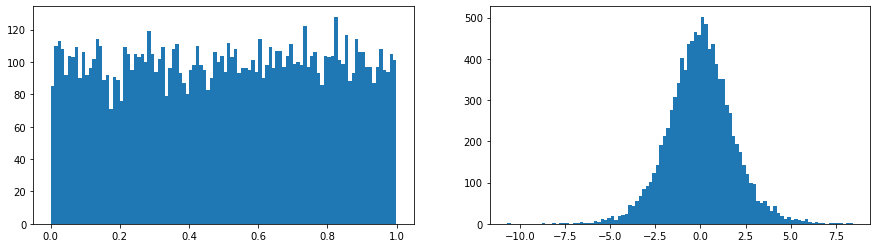

In [8]:
#we can see that the logit(normalized_ranks) are normally distrubuted, 
#which is what you would expect when logit-transforming a uniformly-distributed density

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

_ = ax[0].hist(np.random.choice(normalized_ranks, 10000), bins=100)
_ = ax[1].hist(logit(np.random.choice(normalized_ranks, 10000)), bins=100)

In [9]:
#this holds the ranks of the in vitro tested molecules:
ranks = normalized_ranks[-df['Energy'].shape[0]:]
hits = df['Inhibition (%) at 10uM'].values.astype(float)>50


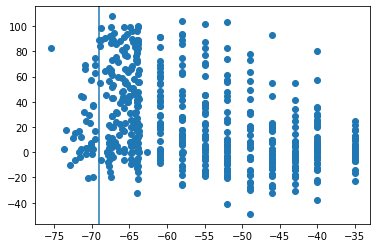

In [10]:
plt.scatter(df['Energy'], df['Inhibition (%) at 10uM'].values.astype(float))
plt.axvline(-69)

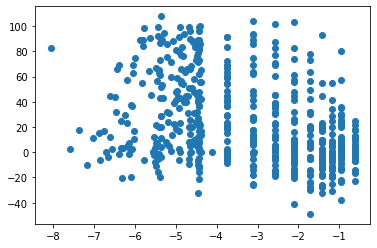

In [11]:
#observe that this resembles Lyu et al, except the points at the bottom of the 
#curve are bunched a bit closer. This more accurately represents
#where the tested range sits in comparison to the rest of the distribution.


plt.scatter(np.log10(ranks), df['Inhibition (%) at 10uM'].values.astype(float))

# Test a GAM fit using log10-transformed ranks

I also manually defined some bins for visualization purposes.

The log10 fit is equivalent to the logit-fit below, but the logit operation is better associated with ranks due to its use in logit-rank models: https://doi.org/10.1111/1467-9876.00147



In [16]:
from pygam import s, GAM

#gam = LinearGAM(s(0, n_splines=8,)).fit(np.log10(ranks)[:,None],  hits.astype(int))
gam = GAM(s(0, n_splines=8,), 
          distribution='binomial',
          link='logit',
          #distribution='normal',
          #link='log',
         ).fit(np.log10(ranks)[:,None],  
               hits.astype(int))


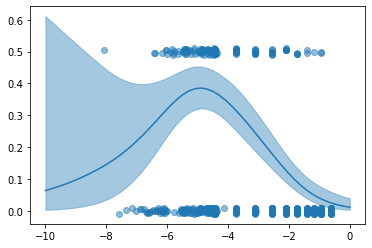

In [17]:
x = np.linspace(-10, 0)[:,None]
plt.plot(x, gam.predict(x))
plt.scatter(np.log10(ranks), 
            (df['Inhibition (%) at 10uM'].values.astype(float)>50) / 2 + \
            np.random.uniform(-0.01, 0.01, len(ranks)),
           alpha=0.5)
plt.fill_between(x.ravel(), *gam.confidence_intervals(x).T, alpha=0.4, color='C0')

12


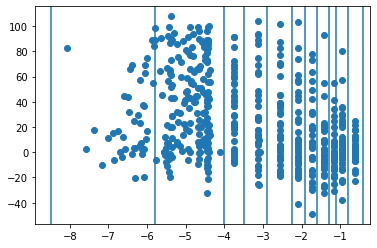

In [18]:
plt.scatter(np.log10(ranks), df['Inhibition (%) at 10uM'].values.astype(float))
bins = [-8.5, -5.8, -4, -3.5, -2.9, -2.25, -1.9, -1.6, -1.3, -1.1, -0.8, -.4]
print(len(bins))
for b in bins:
    plt.axvline(b)

In [19]:
#generate the binned data with confidence intervals for visualization purposes:

idx = np.digitize(np.log10(ranks), bins)


df_prop = pd.DataFrame(columns=['x', 'y', 'y1', 'y2'])
for i in range(1, idx.max()+1):
    samples = hits[idx==i]
    propci = proportion_confint(samples.sum(), nobs=len(samples), method='jeffreys')
    print(samples.mean(), propci)
    df_prop.loc[i-1] = [100*10**((bins[i-1]+bins[i])/2), samples.mean(), propci[0], propci[1]]

0.2619047619047619 (0.1478425384913987, 0.407508371484117)
0.37777777777777777 (0.309354714247769, 0.4500960307646984)
0.3157894736842105 (0.1856138501203135, 0.4728433710422403)
0.23684210526315788 (0.12415617766169264, 0.38788297874502586)
0.175 (0.08185393408002506, 0.31317231261408185)
0.15789473684210525 (0.0687035882721138, 0.2968271998403339)
0.1111111111111111 (0.03868714601646236, 0.2428730120234911)
0.05714285714285714 (0.012063652129890362, 0.17091684882105385)
0.027777777777777776 (0.0030136938252919216, 0.12257359234796428)
0.05714285714285714 (0.012063652129890362, 0.17091684882105385)
0.0 (1.3929610979532534e-05, 0.06877653611605908)


In [20]:
base = alt.Chart(df_prop).transform_calculate(

)

# generate the points
points = base.mark_point(
    filled=True,
    size=50,
    color='black'
).encode(
    x=alt.X('x', scale=alt.Scale(type='log')),
    y=alt.Y('y', title='In vitro hit rate'),
)

# generate the error bars
errorbars = base.mark_errorbar().encode(
    x=alt.X("x",scale=alt.Scale(type='log')),
    y=alt.Y('y1:Q',title='In vitro hit rate'),
    y2="y2:Q"
)

In [21]:
x = np.linspace(-8, -.25)[:,None]
df_ = pd.DataFrame({'x':10**x.ravel()*100, 
                   'y':gam.predict(x), 
                  'y1':gam.confidence_intervals(x).T[0],
                 'y2':gam.confidence_intervals(x).T[1]})

ch = alt.Chart(df_).mark_line(opacity=0.4).encode(
    x=alt.X('x:Q', title='Percentile docking score', scale=alt.Scale(type='log')),
    y=alt.Y('y:Q', title='In vitro hit rate'),
)


ci = alt.Chart(df_).mark_area(opacity=0.3).encode(
    x=alt.X('x:Q', scale=alt.Scale(type='log')),
    y=alt.Y('y1:Q',title='In vitro hit rate'),
    y2='y2:Q'
)


In [22]:
points+errorbars+ch+ci

alt.LayerChart(...)

# GAM using logit-transformed ranks.
The log10 fit is equivalent to the logit-fit below, but the logit operation is better associated with ranks due to its use in logit-rank models: https://doi.org/10.1111/1467-9876.00147


In [24]:
#this holds the ranks of the in vitro tested molecules:
ranks = normalized_ranks[-df['Energy'].shape[0]:]
hits = df['Inhibition (%) at 10uM'].values.astype(float)>50

12


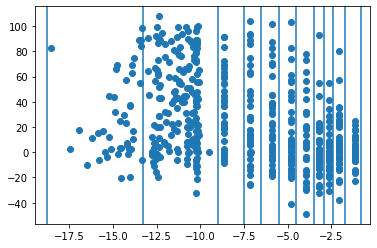

In [25]:
plt.scatter(logit(ranks), df['Inhibition (%) at 10uM'].values.astype(float))
bins = np.array([-18.8, -13.3, -9, -7.5, -6.5, -5.5, -4.5, -3.5, -2.9, -2.4, -1.7, -0.8,])
print(len(bins))
for b in bins:
    plt.axvline(b)

In [26]:
#generate the binned data with confidence intervals for visualization purposes:

idx = np.digitize(logit(ranks), bins)


df_prop = pd.DataFrame(columns=['x', 'y', 'y1', 'y2'])
for i in range(1, idx.max()+1):
    samples = hits[idx==i]
    propci = proportion_confint(samples.sum(), nobs=len(samples), method='jeffreys')
    print(samples.mean(), propci)
    df_prop.loc[i-1] = [100*expit((bins[i-1]+bins[i])/2), samples.mean(), propci[0], propci[1]]
    

0.2727272727272727 (0.1585602290773268, 0.41568899787741154)
0.37640449438202245 (0.3076865633757363, 0.44910522866970504)
0.3157894736842105 (0.1856138501203135, 0.4728433710422403)
0.23684210526315788 (0.12415617766169264, 0.38788297874502586)
0.175 (0.08185393408002506, 0.31317231261408185)
0.15789473684210525 (0.0687035882721138, 0.2968271998403339)
0.1111111111111111 (0.03868714601646236, 0.2428730120234911)
0.05714285714285714 (0.012063652129890362, 0.17091684882105385)
0.027777777777777776 (0.0030136938252919216, 0.12257359234796428)
0.05714285714285714 (0.012063652129890362, 0.17091684882105385)
0.0 (1.3929610979532534e-05, 0.06877653611605908)


In [27]:
base = alt.Chart(df_prop).transform_calculate(

)

# generate the points
points = base.mark_point(
    filled=True,
    size=50,
    color='black'
).encode(
    x=alt.X('x', scale=alt.Scale(type='log')),
    y=alt.Y('y', title='In vitro hit rate'),
)

# generate the error bars
errorbars = base.mark_errorbar().encode(
    x=alt.X("x",scale=alt.Scale(type='log')),
    y=alt.Y('y1:Q',title='In vitro hit rate'),
    y2="y2:Q"
)

In [28]:

gam = GAM(s(0, n_splines=8,), 
          distribution='binomial',
          link='logit',
          #distribution='normal',
          #link='log',
         ).fit(logit(ranks)[:,None],  
               hits.astype(int))


In [29]:
x = np.linspace(-20, 10)[:,None]
df_ = pd.DataFrame({'x':expit(x.ravel())*100, 
                   'y':gam.predict(x), 
                  'y1':gam.confidence_intervals(x).T[0],
                 'y2':gam.confidence_intervals(x).T[1]})

ch = alt.Chart(df_).mark_line(opacity=0.4).encode(
    x=alt.X('x:Q', title='Percentile docking score', scale=alt.Scale(type='log')),
    y=alt.Y('y:Q', title='In vitro hit rate'),
)


ci = alt.Chart(df_).mark_area(opacity=0.3).encode(
    x=alt.X('x:Q', scale=alt.Scale(type='log')),
    y=alt.Y('y1:Q',title='In vitro hit rate'),
    y2='y2:Q'
)


In [30]:
points+errorbars+ch+ci

alt.LayerChart(...)

In [44]:
(points+errorbars+ch+ci).save('../figures/hit_rate_vs_rank.html')